![job image](job.jpg "Job image")

# Role2Skills Project
The idea is a system which extracts skills from job descriptions and uses machine learning to cluster and classify job roles, revealing which skill combinations define different professions and what competencies are most demanded on the job market.

In [55]:
# Imports
import re
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams.update({
    "figure.facecolor": "white",
    "axes.facecolor": "white",
    "savefig.facecolor": "white",
    "axes.edgecolor": "black",
    "text.color": "black",
    "axes.labelcolor": "black",
    "xtick.color": "black",
    "ytick.color": "black",
    "grid.color": "0.85",
})

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.decomposition import PCA

In [56]:
# Load data
CSV_PATH = "data/yandex vacancies eng.csv"
df = pd.read_csv(CSV_PATH)

df.head()


,Header,Emoji,Description,Requirements,Tasks,Pluses,Hashtags,Link,Raw text
0,Senior Java Developer at Music,🎧,"You'll be working with high-load, large-data p...","• Strong knowledge of Java, DBMS, and Linux\n•...","• design new features, support and develop exi...",• experience developing distributed systems wi...,Senior Java Frontend,https://ya.cc/t/26NhxwD4CH6Ur,Senior Java Developer at Music🎧\n\nYou'll be w...
1,Python developer at Yandex.Lavka,🍔,Yandex.Lavka is a 15-minute grocery delivery s...,• Three years of experience in Python\n• Exper...,• create new features\n• work on product archi...,• experience in designing and developing high-...,python,https://ya.cc/t/XcMZJL3TCH7gZ,Python Developer at Yandex.Lavka 🍔\n\nYandex.L...
2,Front-end developer at Vertical,🏠,The verticals are classifieds services: Avto.r...,• Experience developing with JS and Node.js\n•...,• Develop desktop and mobile interfaces for va...,"• experience with TypeScript, Docker and CI/CD...",React frontend,https://ya.cc/t/P-Ndw5BUCGcUm,Frontend Developer at Vertical 🏠\n\nVerticals ...
3,iOS Developer at Vertical (Bootcamp),🍏,The verticals are classifieds services: Avto.r...,• At least two years of commercial iOS develop...,"• design new application features, support and...",• experience in multithreaded programming and ...,mobile iOS,https://ya.cc/t/9eoluR6OCGcqY,iOS Developer in Verticals (Bootcamp)🍏\n\nVert...
4,Senior Developer in the Serverless Computing D...,👨,Yandex Functions is a serverless computing sys...,• experience developing in C++\n• understand t...,• address issues of isolation of both data and...,• experience with virtualization and container...,CPP,https://ya.cc/t/zFsx4utJCP6MH,Senior Developer in the Serverless Computing D...


In [57]:
# Basic cleaning

if "Requirements" in df.columns:
    df["Requirements"] = df["Requirements"].fillna("")
else:
    df["Requirements"] = ""

if "Description" in df.columns:
    df["Description"] = df["Description"].fillna("")
else:
    df["Description"] = ""

# Category may not exist in the dataset
if "Category" in df.columns:
    df["Category"] = df["Category"].fillna("unknown")
else:
    df["Category"] = "unknown"

# Combine text for skill extraction
df["text"] = (
    df["Requirements"].astype(str) + "\n" +
    df["Description"].astype(str)
).str.lower()

# Text length features
df["req_word_count"] = df["Requirements"].astype(str).str.split().str.len()
df["desc_word_count"] = df["Description"].astype(str).str.split().str.len()


In [58]:
# Key = canonical name, value = regex that matches common variants

skills_regex = {
    # Languages
    "python": r"\bpython\b",
    "java": r"\bjava\b",
    "kotlin": r"\bkotlin\b",
    "swift": r"\bswift\b",
    "go": r"\bgolang\b|\bgo\b",
    "ruby": r"\bruby\b",
    "php": r"\bphp\b",
    "scala": r"\bscala\b",
    "c": r"\bc\b(?!\+|\#)",               # tries to avoid catching c++ / c#
    "c++": r"\bc\+\+\b|\bcpp\b",
    "c#": r"\bc\#\b|c\s*sharp",
    ".net": r"\.net\b|dotnet",
    "javascript": r"\bjavascript\b|\bjs\b",
    "typescript": r"\btypescript\b|\bts\b",

    # Web / frontend
    "html": r"\bhtml\b",
    "css": r"\bcss\b",
    "sass": r"\bsass\b|\bscss\b",
    "react": r"\breact\b",
    "next.js": r"\bnext\.?js\b",
    "vue": r"\bvue\b|\bvue\.?js\b",
    "angular": r"\bangular\b",
    "redux": r"\bredux\b",

    # Backend / frameworks
    "node.js": r"\bnode\.?js\b|\bnodejs\b",
    "express": r"\bexpress\b",
    "nestjs": r"\bnest\.?js\b|\bnestjs\b",
    "spring": r"\bspring\b",
    "spring boot": r"\bspring\s*boot\b",
    "django": r"\bdjango\b",
    "flask": r"\bflask\b",
    "fastapi": r"\bfastapi\b",
    "laravel": r"\blaravel\b",
    "rails": r"\brails\b|ruby on rails",

    # Databases
    "sql": r"\bsql\b",
    "postgresql": r"\bpostgres(?:ql)?\b",
    "mysql": r"\bmysql\b",
    "mongodb": r"\bmongo(?:db)?\b",
    "redis": r"\bredis\b",
    "elasticsearch": r"\belasticsearch\b|\belk\b",

    # DevOps / cloud
    "linux": r"\blinux\b",
    "git": r"\bgit\b",
    "docker": r"\bdocker\b",
    "kubernetes": r"\bkubernetes\b|\bk8s\b",
    "terraform": r"\bterraform\b",
    "ansible": r"\bansible\b",
    "ci/cd": r"\bci\/cd\b|\bcicd\b|\bcontinuous integration\b",
    "aws": r"\baws\b|amazon web services",
    "gcp": r"\bgcp\b|google cloud",
    "azure": r"\bazure\b|microsoft azure",

    # APIs / messaging
    "rest": r"\brest\b|\brestful\b",
    "graphql": r"\bgraphql\b",
    "grpc": r"\bgrpc\b",
    "kafka": r"\bkafka\b",
    "rabbitmq": r"\brabbitmq\b",

    # Data / ML
    "pandas": r"\bpandas\b",
    "numpy": r"\bnumpy\b",
    "scikit-learn": r"scikit[-\s]?learn|\bsklearn\b",
    "pytorch": r"\bpytorch\b",
    "tensorflow": r"\btensorflow\b",
    "spark": r"\bspark\b|\bpyspark\b",
    "airflow": r"\bairflow\b",
}


In [59]:
# Skill extraction
def extract_skills(text):
    found = []
    for skill, pattern in skills_regex.items():
        if re.search(pattern, text, flags=re.IGNORECASE):
            found.append(skill)
    return found

df["skills"] = df["text"].apply(extract_skills)
df["skills_count"] = df["skills"].apply(len)

df[["skills", "skills_count"]].head()


,skills,skills_count
0,"[java, linux]",2
1,"[python, git]",2
2,"[javascript, react, redux, node.js]",4
3,"[swift, c]",2
4,[],0


In [60]:
# Plot helpers
def plot_hist(series, title, xlabel, bins=30):
    plt.figure()
    plt.hist(series.dropna(), bins=bins)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Count")
    plt.show()


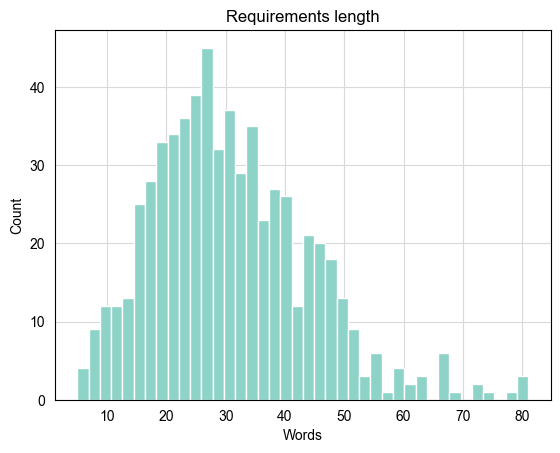

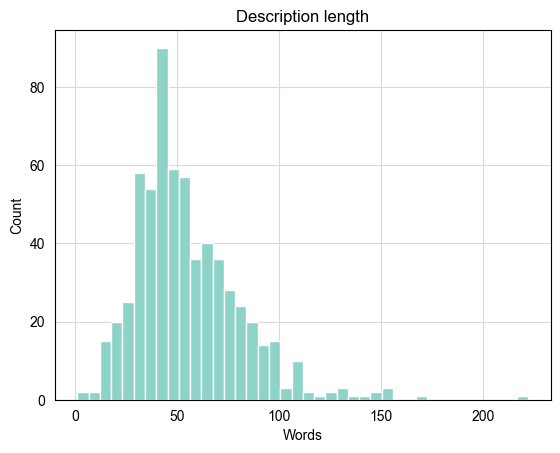

In [61]:
# Text length analysis
plot_hist(df["req_word_count"], "Requirements length", "Words", bins=40)
plot_hist(df["desc_word_count"], "Description length", "Words", bins=40)


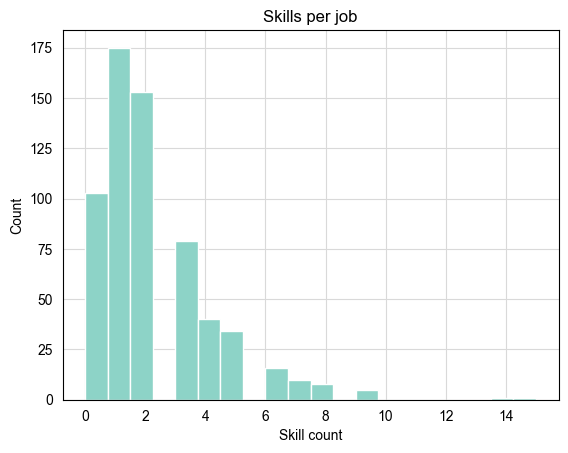

In [62]:
# Skills per job
plot_hist(df["skills_count"], "Skills per job", "Skill count", bins=20)


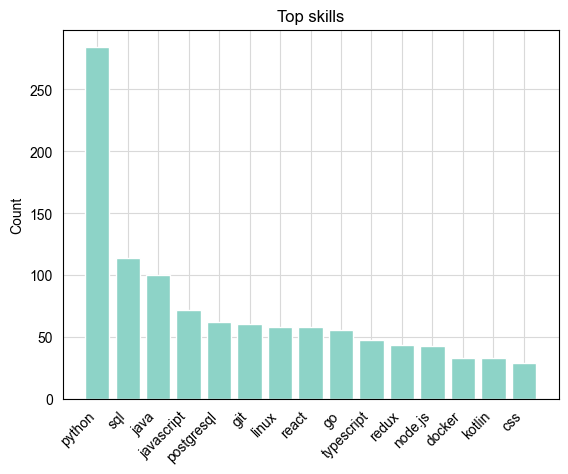

In [63]:
# Skill frequency
all_skills = [s for row in df["skills"] for s in row]
skill_freq = Counter(all_skills)

top = skill_freq.most_common(15)
labels = [k for k, _ in top]
values = [v for _, v in top]

plt.figure()
plt.bar(labels, values)
plt.xticks(rotation=45, ha="right")
plt.title("Top skills")
plt.ylabel("Count")
plt.show()


In [64]:
# Filter skills by document frequency
N = len(df)
skill_doc_freq = Counter()

for row in df["skills"]:
    for s in set(row):
        skill_doc_freq[s] += 1

min_df = max(2, int(0.01 * N))
max_df = int(0.7 * N)

kept_skills = [
    s for s, c in skill_doc_freq.items()
    if min_df <= c <= max_df
]

kept_skills


['linux',
 'java',
 'python',
 'git',
 'react',
 'node.js',
 'redux',
 'javascript',
 'swift',
 'c',
 'docker',
 'go',
 'typescript',
 'html',
 'css',
 'kotlin',
 'sql',
 'rest',
 'postgresql',
 'mysql',
 'mongodb',
 'redis',
 'tensorflow',
 'spring',
 'pytorch',
 'express',
 'pandas',
 'c++',
 'django',
 'php',
 'ci/cd',
 'spark',
 'numpy']

In [65]:
# Build skill matrix
def filter_skills(skills):
    return [s for s in skills if s in kept_skills]

df["skills_filtered"] = df["skills"].apply(filter_skills)

mlb = MultiLabelBinarizer(classes=kept_skills)
X = mlb.fit_transform(df["skills_filtered"])

X.shape


(625, 33)

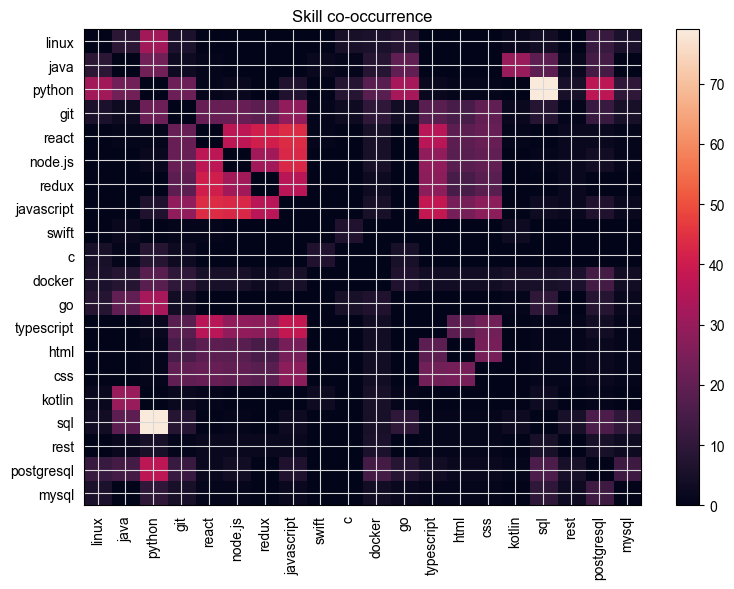

In [66]:
# Co-occurrence heatmap
co = (X.T @ X).astype(int)
np.fill_diagonal(co, 0)

top_skills = kept_skills[:20]
idx = [kept_skills.index(s) for s in top_skills]
co_top = co[np.ix_(idx, idx)]

plt.figure(figsize=(8, 6))
plt.imshow(co_top, aspect="auto")
plt.xticks(range(len(top_skills)), top_skills, rotation=90)
plt.yticks(range(len(top_skills)), top_skills)
plt.title("Skill co-occurrence")
plt.colorbar()
plt.tight_layout()
plt.show()


# Model building
hdbscan for unsupervised learning
might also switch to lda or bertopic in the future if needed

In [67]:
import hdbscan

clusterer = hdbscan.HDBSCAN(
    min_cluster_size=10,      # role minimal size
    min_samples=5,
    metric="euclidean",
    cluster_selection_method="eom"
)

labels = clusterer.fit_predict(X)

df["cluster"] = labels


In [68]:
df["cluster"].value_counts().sort_index()

cluster
-1     205
 0      15
 1      11
 2      10
 3      14
 4     110
 5      18
 6      26
 7      20
 8      53
 9      13
 10     14
 11    104
 12     12
Name: count, dtype: int64

In [69]:
from collections import Counter

cluster_skills = []

for cl in sorted(df["cluster"].unique()):
    if cl == -1:
        continue

    subset = df[df["cluster"] == cl]
    freq = Counter([s for row in subset["skills_filtered"] for s in row])

    cluster_skills.append({
        "cluster": cl,
        "size": len(subset),
        "top_skills": ", ".join([s for s, _ in freq.most_common(10)])
    })

pd.DataFrame(cluster_skills).sort_values("size", ascending=False)

,cluster,size,top_skills
4,4,110,"python, git, c, tensorflow, spark"
11,11,104,
8,8,53,"python, sql, linux, express, git"
6,6,26,"kotlin, java, docker, sql, git"
7,7,20,java
5,5,18,"react, javascript, redux, node.js, typescript,..."
0,0,15,"javascript, css, react, redux, node.js, typesc..."
3,3,14,"go, python, c, docker"
10,10,14,"python, linux, ci/cd, go"
9,9,13,"sql, git, mysql"


HDBSCAN labels dense groups of similar vacancies as clusters, while assigning less common or ambiguous vacancies to noise (cluster -1).
A minimum cluster size of 10 was used, meaning that only job role types with at least 10 similar vacancies were considered stable clusters.

In [70]:
df[df["cluster"] == 0][["Header", "skills"]].head(5)

,Header,skills
14,Interface Developer in Video,"[javascript, typescript, html, css, react, red..."
30,Interface Developer in Video,"[javascript, typescript, html, css, react, red..."
71,Interface Developer in Video,"[javascript, typescript, html, css, react, red..."
313,Lead Interface Developer at Help Nearby,"[javascript, typescript, html, css, react, red..."
316,Interface Developer at Mail,"[javascript, typescript, html, css, react, red..."


Using HDBSCAN, several coherent clusters were identified based on skill co-occurrence.
The clusters correspond to common job roles such as frontend development,
backend development, data-oriented roles, and DevOps.
A significant portion of vacancies was labeled as noise, which is expected due to
generic or weakly specified skill requirements.
Overall, the clustering results demonstrate that technical roles can be
effectively grouped using skill-based representations.
